# 🌿 iNature — Análise e Modelagem de Dados para Classificação de Desastres Naturais

> Estudo exploratório e comparativo de algoritmos de classificação aplicados ao cenário de desastres naturais.

## 1. Importando a base

In [1]:
# acessando o drive para baixar a base
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Global Solution - 2025-1/natural_disasters.csv')

# exibir colunas da base de dados
print("Total de colunas:", len(df.columns))
for col in df.columns:
    print(col, end=', ')


Total de colunas: 45
Year, Seq, Glide, Disaster Group, Disaster Subgroup, Disaster Type, Disaster Subtype, Disaster Subsubtype, Event Name, Country, ISO, Region, Continent, Location, Origin, Associated Dis, Associated Dis2, OFDA Response, Appeal, Declaration, Aid Contribution, Dis Mag Value, Dis Mag Scale, Latitude, Longitude, Local Time, River Basin, Start Year, Start Month, Start Day, End Year, End Month, End Day, Total Deaths, No Injured, No Affected, No Homeless, Total Affected, Insured Damages ('000 US$), Total Damages ('000 US$), CPI, Adm Level, Admin1 Code, Admin2 Code, Geo Locations, 

### 🎯 Seleção de Variáveis para o Modelo de Classificação

O objetivo deste projeto é prever o **tipo de desastre natural** com base em dados históricos e de impacto. Para isso, selecionamos as seguintes colunas com suas respectivas justificativas:

#### ✅ Colunas Mantidas:

- **Disaster Type**: variável alvo (target), representa o tipo de desastre a ser previsto.
- **Year, Start Month, Start Day**: informações temporais que podem indicar sazonalidade ou tendências.
- **Country, Region, Continent**: localização geográfica relevante, pois certos desastres são comuns em determinadas áreas.
- **Latitude, Longitude**: dados espaciais que complementam a localização.
- **Total Deaths, No Injured, No Affected, No Homeless, Total Affected**: impacto humano direto e indireto.
- **Total Damages ('000 US$)**: impacto econômico total do evento.
- **Dis Mag Value, Dis Mag Scale**: intensidade do desastre (quando aplicável, como terremotos e ciclones).

In [4]:
# lista de colunas selecionadas
colunas_selecionadas = [
    'Year', 'Start Month', 'Start Day',
    'Country', 'Region', 'Continent',
    'Latitude', 'Longitude',
    'Total Deaths', 'No Injured', 'No Affected', 'No Homeless', 'Total Affected',
    "Total Damages ('000 US$)", 'Dis Mag Value', 'Dis Mag Scale',
    'Disaster Type'  # alvo
]

# manter somente as colunas da lista
df = df.loc[:, colunas_selecionadas].copy()
df.head()

,Year,Start Month,Start Day,Country,Region,Continent,Latitude,Longitude,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Total Damages ('000 US$),Dis Mag Value,Dis Mag Scale,Disaster Type
0,1900,NaN,NaN,Cabo Verde,Western Africa,Africa,NaN,NaN,11000.0,NaN,NaN,NaN,NaN,NaN,NaN,Km2,Drought
1,1900,NaN,NaN,India,Southern Asia,Asia,NaN,NaN,1250000.0,NaN,NaN,NaN,NaN,NaN,NaN,Km2,Drought
2,1902,4.0,18.0,Guatemala,Central America,Americas,14,-91,2000.0,NaN,NaN,NaN,NaN,25000.0,8.0,Richter,Earthquake
3,1902,4.0,8.0,Guatemala,Central America,Americas,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Volcanic activity
4,1902,10.0,24.0,Guatemala,Central America,Americas,NaN,NaN,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Volcanic activity


In [5]:
# informações gerais da base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16126 entries, 0 to 16125
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      16126 non-null  int64  
 1   Start Month               15739 non-null  float64
 2   Start Day                 12498 non-null  float64
 3   Country                   16126 non-null  object 
 4   Region                    16126 non-null  object 
 5   Continent                 16126 non-null  object 
 6   Latitude                  2729 non-null   object 
 7   Longitude                 2732 non-null   object 
 8   Total Deaths              11413 non-null  float64
 9   No Injured                3895 non-null   float64
 10  No Affected               9220 non-null   float64
 11  No Homeless               2430 non-null   float64
 12  Total Affected            11617 non-null  float64
 13  Total Damages ('000 US$)  5245 non-null   float64
 14  Dis Ma

In [6]:
# tipos distintos de desastre da base, que representam nossa variável alvo
df['Disaster Type'].unique()

array(['Drought', 'Earthquake', 'Volcanic activity',
       'Mass movement (dry)', 'Storm', 'Flood', 'Epidemic', 'Landslide',
       'Wildfire', 'Extreme temperature ', 'Fog', 'Insect infestation',
       'Impact', 'Animal accident', 'Glacial lake outburst'], dtype=object)

## 2. Visualização da distribuição da variável alvo

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

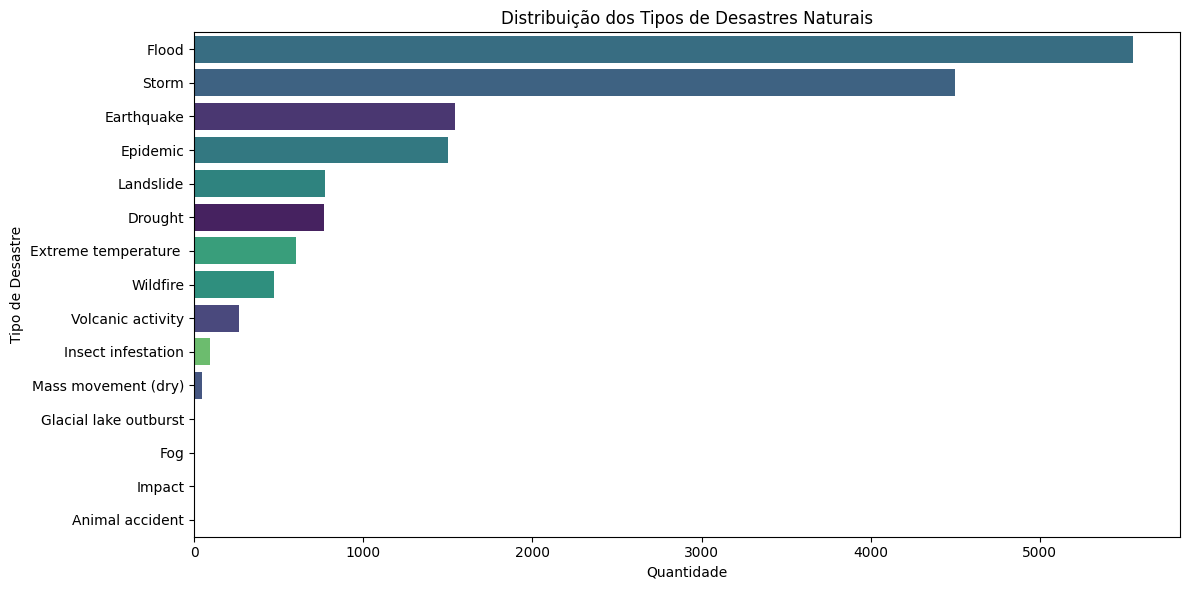

In [8]:
# contagem dos tipos de desastre
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    y='Disaster Type',
    hue='Disaster Type',
    order=df['Disaster Type'].value_counts().index,
    palette='viridis',
    legend=False
)
plt.title('Distribuição dos Tipos de Desastres Naturais')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de Desastre')
plt.tight_layout()
plt.show()


### 📌 Filtragem de Classes Raras

#### Para evitar problemas na etapa de modelagem, como métricas indefinidas e má performance em classes pouco representadas, vamos remover classes com menos de 4 ocorrências no dataset. Essa filtragem garante que o modelo tenha exemplos suficientes para aprender de forma significativa em cada classe.

In [9]:
# contar ocorrências por classe
contagem_classes = df['Disaster Type'].value_counts()
print(contagem_classes)

# filtrar apenas as classes com mais de 100 ocorrências
limite = 100
classes_suficientes = contagem_classes[contagem_classes >= limite].index

# shape do dataset antes de aplicar o filtro
shape_antigo = df.shape

# aplicar o filtro na base
df = df[df['Disaster Type'].isin(classes_suficientes)].copy()

print(f"Número de classes antes do filtro: {len(contagem_classes)}")
print(f"Número de classes após filtro: {len(classes_suficientes)}")
print(f"Tamanho do dataset antes do filtro: {shape_antigo}")
print(f"Tamanho do dataset após filtro: {df.shape}")


Disaster Type
Flood                    5551
Storm                    4496
Earthquake               1544
Epidemic                 1501
Landslide                 776
Drought                   770
Extreme temperature       603
Wildfire                  471
Volcanic activity         265
Insect infestation         96
Mass movement (dry)        48
Glacial lake outburst       2
Fog                         1
Impact                      1
Animal accident             1
Name: count, dtype: int64
Número de classes antes do filtro: 15
Número de classes após filtro: 9
Tamanho do dataset antes do filtro: (16126, 17)
Tamanho do dataset após filtro: (15977, 17)


## 3. Análise e tratamento de valores ausentes

In [10]:
# verificando valores nulos
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100

# exibindo apenas colunas com dados faltantes
missing_df = pd.DataFrame({
    'Valores Nulos': missing,
    'Porcentagem (%)': missing_percent
}).query('`Valores Nulos` > 0')

missing_df

,Valores Nulos,Porcentagem (%)
No Homeless,13554,84.834450
Latitude,13248,82.919196
Longitude,13245,82.900419
No Injured,12097,75.715090
Dis Mag Value,11042,69.111848
Total Damages ('000 US$),10742,67.234149
No Affected,6774,42.398448
Total Deaths,4614,28.879014
Total Affected,4388,27.464480
Start Day,3539,22.150591


### 📌 Visão geral do problema:

A maioria dos dados faltantes está concentrada em colunas de **impacto humano, geográfico e magnitude**, o que é comum em eventos de desastres por fatores como:

- Dados indisponíveis na época
- Eventos pequenos sem medição precisa
- Regiões com baixa capacidade de registro

Por isso, é importante diferenciar:

- ❗ Colunas **muito incompletas** que talvez devêssemos excluir
- 🛠️ Colunas **parcialmente completas** que podemos preencher
- ✅ Colunas com **poucos nulos** que podemos tratar facilmente

---

### 📊 Análise e plano de ação:

| Coluna                              | % Nulos   | Ação |
|------------------------------------|-----------|----------------|
| `No Homeless`                      | 84.8%     | **Excluir** (dados demais faltando) |
| `Latitude` / `Longitude`           | 83%       | **Excluir** (ou tentar imputar com país, mas seria incerto) |
| `No Injured`                       | 75.7%     | **Excluir** |
| `Dis Mag Value`                    | 69.1%     | **Excluir** (muitos eventos não têm magnitude registrada) |
| `Total Damages ('000 US$)`         | 67.2%     | **Preencher com 0** (ausência provavelmente significa _sem registro de dano monetário_) |
| `No Affected`, `Total Deaths`, `Total Affected` | 27%–42% | **Preencher com 0** (ausência provavelmente significa não afetados ou não registrados) |
| `Start Day`                        | 22.1%     | **Excluir** (baixa granularidade aceitável: temos ano e mês) |
| `Dis Mag Scale`                    | 6.5%      | **Excluir** (sem `Dis Mag Value`, perde sentido) |
| `Start Month`                      | 2.3%      | **Preencher com moda** (ou excluir poucos registros) |


In [11]:
# excluir colunas muito incompletas
df.drop(columns=[
    'No Homeless', 'Latitude', 'Longitude',
    'No Injured', 'Dis Mag Value', 'Dis Mag Scale', 'Start Day'
], inplace=True)

In [12]:
# preencher colunas faltantes com zero
cols_zero = ['Total Damages (\'000 US$)', 'No Affected', 'Total Deaths', 'Total Affected']
df[cols_zero] = df[cols_zero].fillna(0)

In [13]:
# preencher Start Month com a moda
df['Start Month'] = df['Start Month'].fillna(df['Start Month'].mode()[0])

## 4. Análise exploratória

### Distribuição das variáveis numéricas (com transformação log)
-----------------------------------

- Algumas variáveis apresentam cauda longa à direita, dificultando a análise visual.
- Para lidar com isso, aplicamos a transformação logarítmica `log1p`, que suaviza a distribuição sem remover zeros.

In [14]:
import numpy as np

In [15]:
# selecionar apenas colunas numéricas
variaveis_numericas = df.select_dtypes(include='number').columns

# selecionar colunas com maior assimetria (distribuição enviesada)
cols_skewed = ['Total Deaths', 'No Affected', 'Total Affected', "Total Damages ('000 US$)"]

# criar uma cópia do dataframe para aplicar transformação logarítmica
df_log = df.copy()
df_log[cols_skewed] = df_log[cols_skewed].apply(np.log1p)


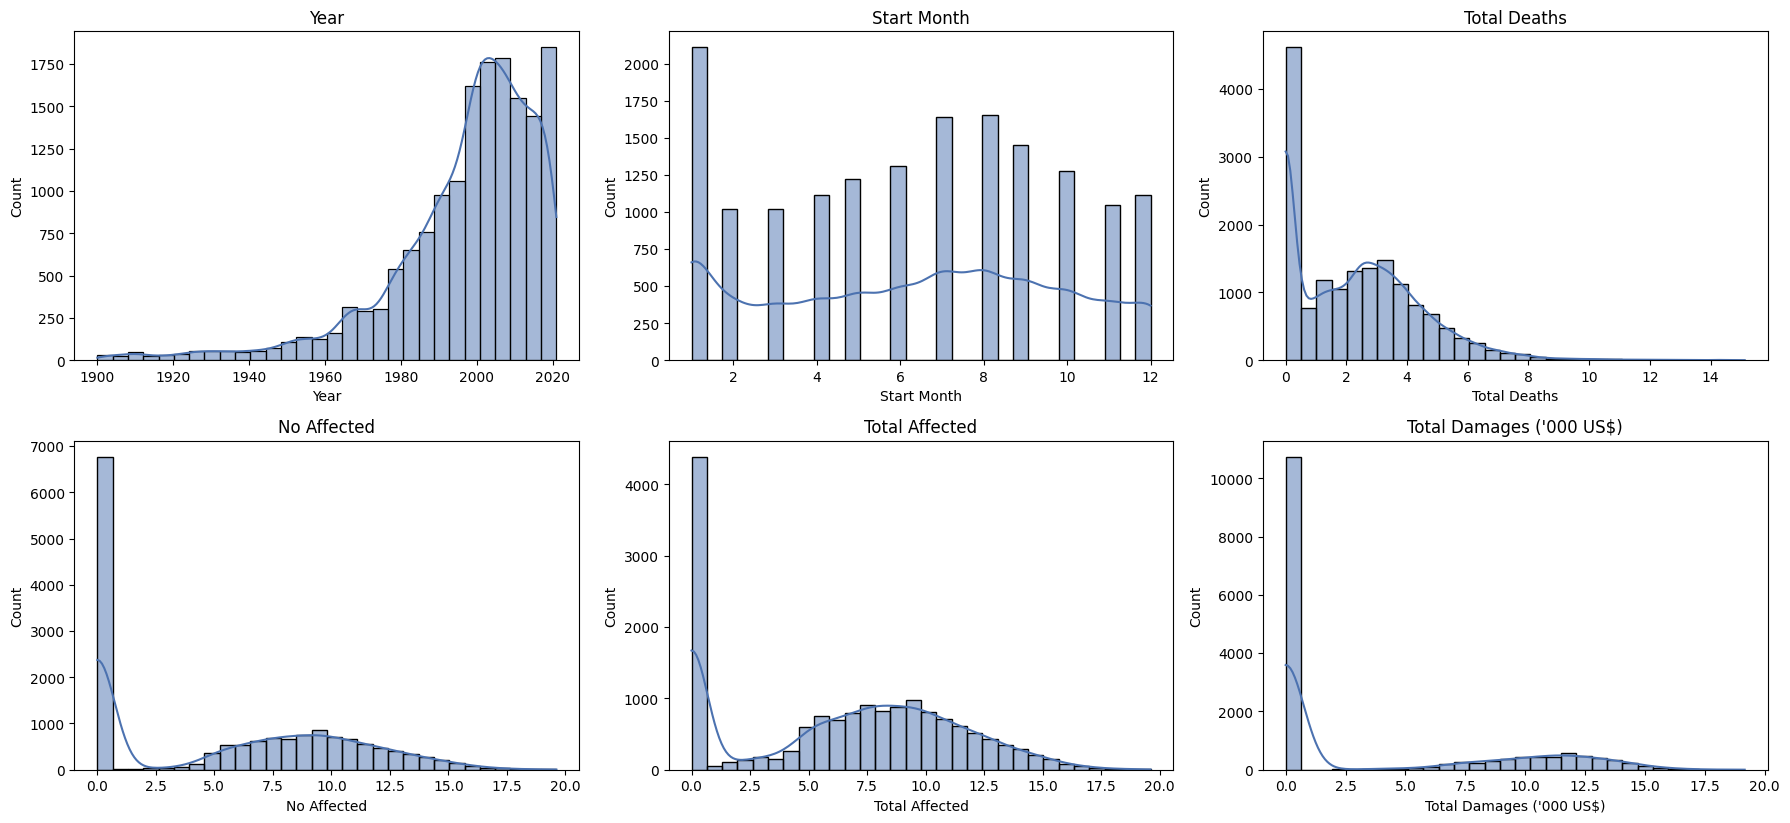

In [16]:
# plotar histogramas das variáveis numéricas após transformação log1p nas colunas enviesadas
plt.figure(figsize=(18, 12))
for i, col in enumerate(variaveis_numericas):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_log[col], kde=True, bins=30, color='#4c72b0')
    plt.title(col)
    plt.tight_layout()
plt.show()

- Year: A maioria dos eventos foi registrada depois de 1980.

- Start Month: Distribuição relativamente uniforme, com pico em janeiro.

- Total Deaths, No Affected, Total Affected, Total Damages:

  - Distribuição muito assimétrica.

  - Poucos eventos com valores muito altos (outliers).

  - A maioria tem impacto baixo.

### Heatmap de correlação
-----------------------------------

- Esta matriz permite observar as correlações entre as variáveis numéricas.
- Utilizamos a versão transformada (`df_log`) para garantir que a escala dos dados enviesados não distorça as relações.
- As correlações observadas são, em geral, fracas, o que pode influenciar a escolha de algoritmos no modelo preditivo.

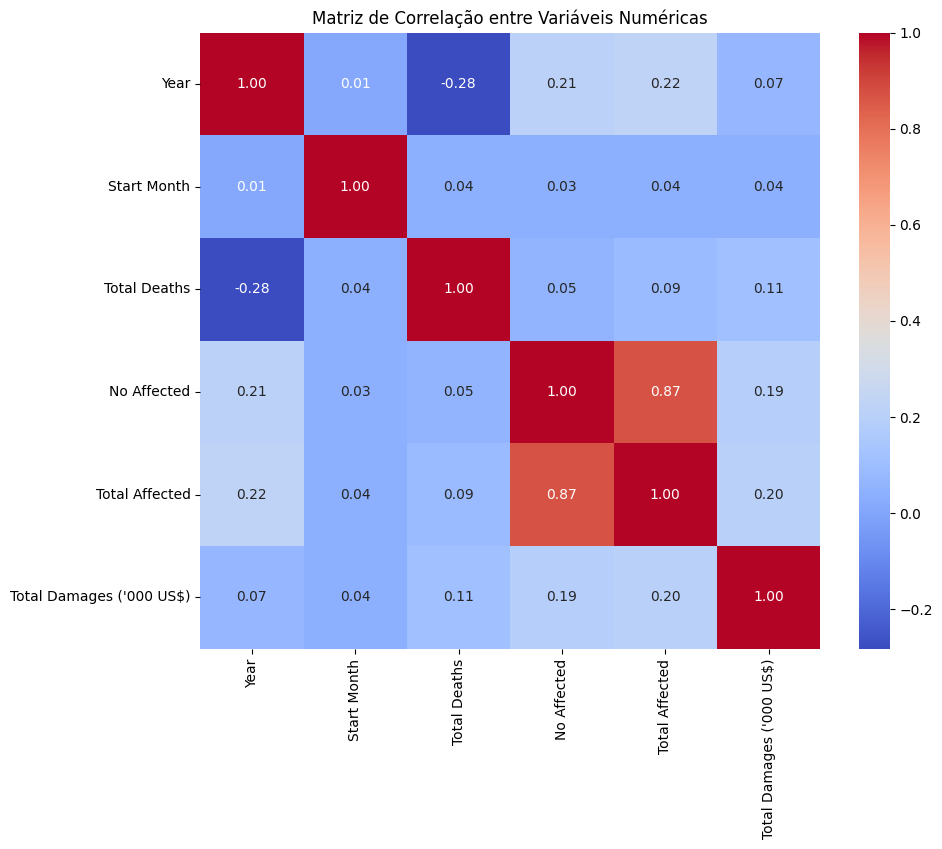

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_log[variaveis_numericas].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

- **Total Affected e No Affected**: Correlação muito forte (0.87), indicando que ambas medem aspectos semelhantes do impacto humano.
- **Year x Total Deaths**: Correlação negativa moderada (-0.28), sugerindo que eventos mais recentes tendem a causar menos mortes.
- **Demais variáveis**: Correlações fracas ou quase nulas, indicando baixa relação linear entre elas.


### Análise das variáveis categóricas

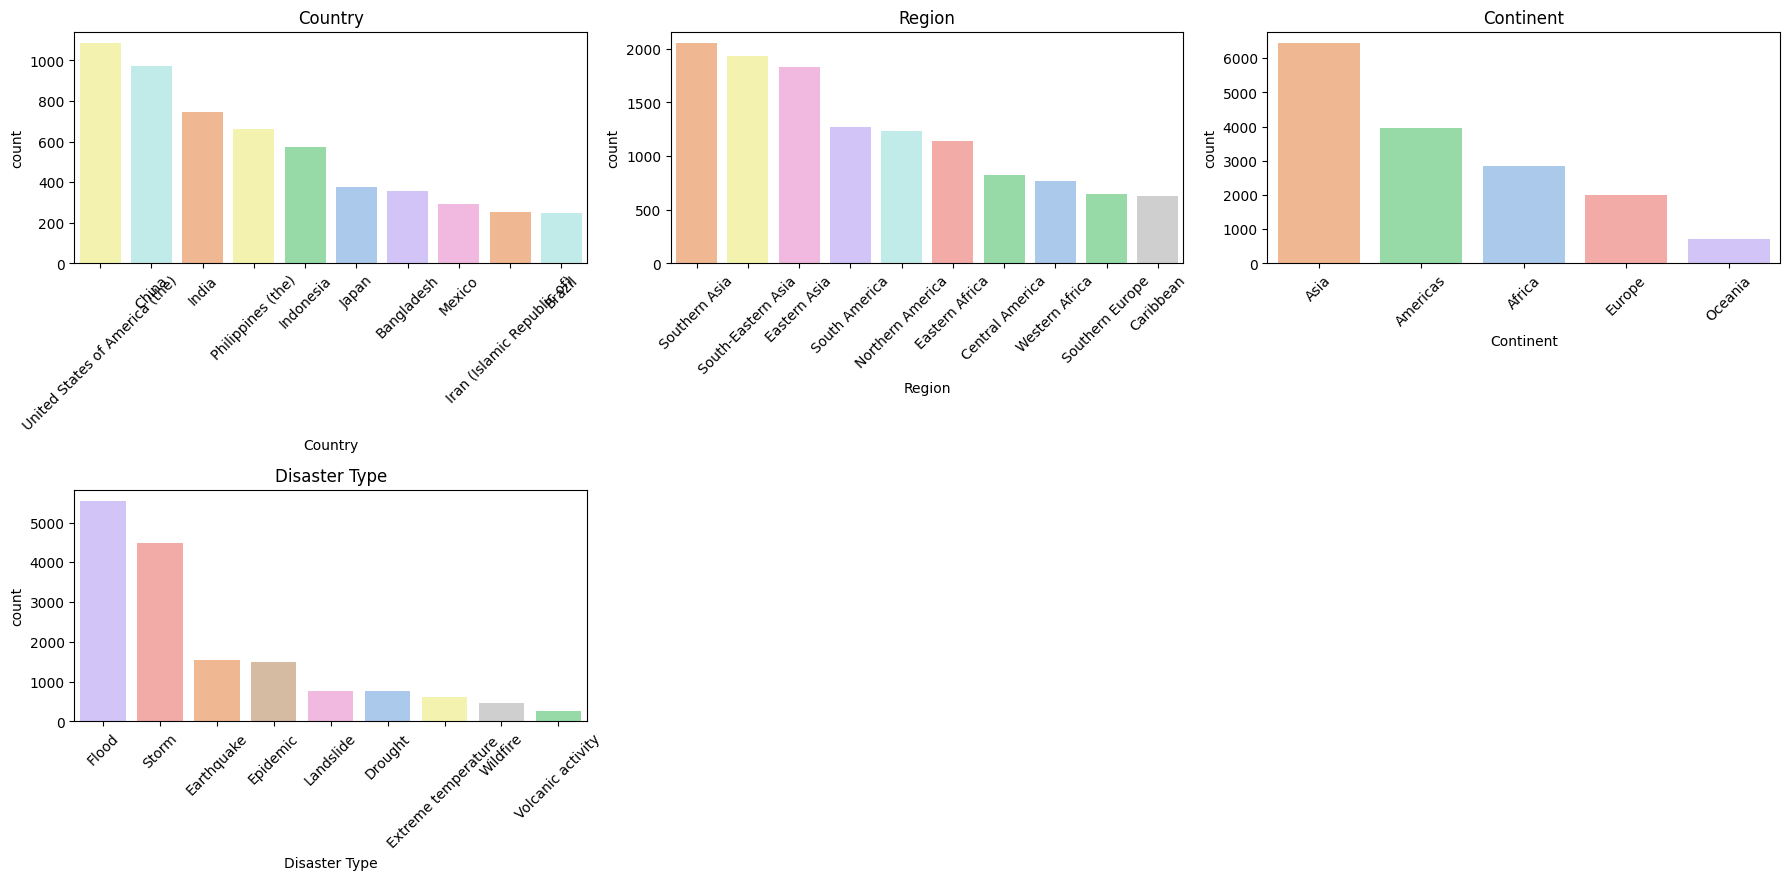

In [18]:
# selecionar apenas variáveis categóricas
variaveis_categoricas = df.select_dtypes(include='object').columns

# visualizar a contagem do top 10 categorias para cada variável categórica
plt.figure(figsize=(18, 12))
for i, col in enumerate(variaveis_categoricas):
    plt.subplot(3, 3, i + 1)
    top_n = 10  # número de categorias a mostrar
    sns.countplot(data=df, x=col, hue=col, order=df[col].value_counts().iloc[:top_n].index, palette='pastel', dodge=False, legend=False)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

## 5. Codificação das variáveis categóricas

### 🎯 Variável Alvo: `Disaster Type`

- Será aplicado **Label Encoding** à variável-alvo para convertê-la em valores numéricos, conforme exigido pela maioria dos algoritmos de classificação.
- O mapeamento entre os nomes dos desastres e seus respectivos códigos numéricos será salvo, para facilitar a interpretação dos resultados posteriormente.

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
# Label Encoding para o alvo
le = LabelEncoder()
df['Disaster Type'] = le.fit_transform(df['Disaster Type'])

# guardar o mapeamento dos tipos de desastre
mapa_disasters = dict(zip(le.classes_, le.transform(le.classes_)))

### 🌍 Variáveis Categóricas de Localização

- As colunas categóricas `Country`, `Region` e `Continent` serão transformadas utilizando **One-Hot Encoding**, o que converte cada categoria em uma nova coluna binária.
- O parâmetro `drop_first=True` será utilizado para evitar o problema de multicolinearidade, conhecido como *dummy variable trap*.

In [21]:
# One-Hot Encoding para Country, Region e Continent
df_encoded = pd.get_dummies(df, columns=['Country', 'Region', 'Continent'], drop_first=True)

### 🧩 Separação entre Features e Alvo

- A variável `X` será composta por todas as colunas explicativas (incluindo dados numéricos e variáveis dummies).
- A variável `y` conterá a variável-alvo (`Disaster Type`), já codificada numericamente.

In [22]:
# separar features (X) e alvo (y)
X = df_encoded.drop('Disaster Type', axis=1)
y = df_encoded['Disaster Type']

## 6. Treinamento e avaliação dos modelos

### Objetivo: dividir o conjunto de dados em treino e teste, treinar modelos de classificação e avaliar seu desempenho com base na variável-alvo `Disaster Type`.

### 🧪 Separação em Conjuntos de Treino e Teste

#### Usando stratify e manter a proporção das classes da variável alvo nos dois conjuntos.

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# dividir com stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### ⚖️ Padronização dos Dados

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
# instanciar e ajustar o scaler com os dados de treino
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 📊 Avaliação com Modelos Base

#### Realizando o treinamento de 3 modelos básicos e comparando os resultados iniciais

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [28]:
# instanciar os modelos
modelos = {
    'Regressão Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42)
}

In [29]:
# treinar e avaliar os modelos
for nome, modelo in modelos.items():
    print(f"\n📌 {nome}")

    # usar dados padronizados (X_train_scaled) quando necessário
    if nome in ['Regressão Logística', 'SVM']:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

    # avaliação
    print("Acurácia:", accuracy_score(y_test, y_pred))
    print("Relatório de Classificação:\n", classification_report(y_test, y_pred))


📌 Regressão Logística
Acurácia: 0.49687108886107634
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.65      0.13      0.22       154
           1       0.51      0.36      0.42       309
           2       0.50      0.38      0.43       300
           3       0.45      0.04      0.08       121
           4       0.48      0.62      0.54      1111
           5       0.00      0.00      0.00       155
           6       0.52      0.72      0.60       899
           7       0.18      0.04      0.06        53
           8       0.17      0.01      0.02        94

    accuracy                           0.50      3196
   macro avg       0.38      0.26      0.26      3196
weighted avg       0.46      0.50      0.45      3196


📌 Random Forest
Acurácia: 0.639549436795995
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.77      0.65      0.70       154
           1       0.61      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 📌 Interpretação dos Resultados
#### 🔍 1. Classes Desbalanceadas

Algumas classes ainda têm menos amostras (como a classe 3, com 111 exemplos), o que ainda impacta recall e f1-score.

As classes com mais exemplos (5, 1, 2) continuam puxando o desempenho médio dos modelos.

Apesar da melhora, o desbalanceamento ainda afeta a macro média dos modelos, refletindo em f1-scores abaixo de 0.55.

#### ⚠️ 2. Problema de “zero precision”
Vários avisos do scikit-learn: algumas classes não foram previstas nenhuma vez.

Isso é esperado em dados desbalanceados com modelos sem ajuste ou sem penalização.

## 6.1. 📉 Matriz de Confusão

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
def plot_matriz_confusao(modelo, nome_modelo, X_test, y_test, labels):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Matriz de Confusão - {nome_modelo}")
    plt.grid(False)
    plt.show()


## 6.2 📋 Tabela Comparativa de Métricas

In [32]:
from sklearn.metrics import f1_score

In [33]:
# armazenar os resultados
resultados = []

for nome, modelo in modelos.items():
    if nome in ['Regressão Logística', 'SVM']:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

    resultados.append({
        'Modelo': nome,
        'Acurácia': accuracy_score(y_test, y_pred),
        'F1-score (Macro)': f1_score(y_test, y_pred, average='macro'),
        'F1-score (Weighted)': f1_score(y_test, y_pred, average='weighted')
    })

df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='F1-score (Macro)', ascending=False)

,Modelo,Acurácia,F1-score (Macro),F1-score (Weighted)
1,Random Forest,0.639549,0.551892,0.631529
0,Regressão Logística,0.496871,0.263337,0.453271
2,SVM,0.480601,0.221923,0.425957


In [34]:
# dicionário com modelos treinados
modelos_treinados = {}

# lista para guardar os resultados
resultados = []

# lista de rótulos (classes possíveis)
classes_unicas = sorted(y.unique())

<Figure size 1000x800 with 0 Axes>

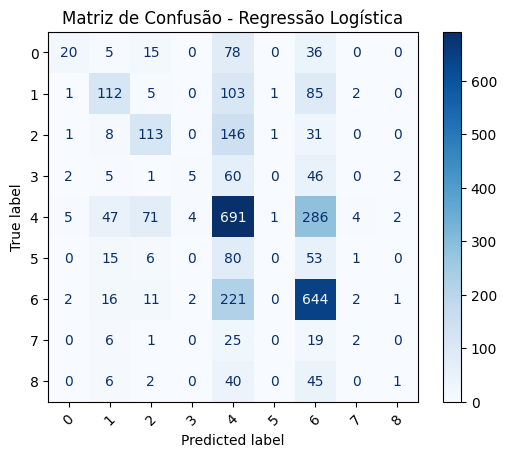

<Figure size 1000x800 with 0 Axes>

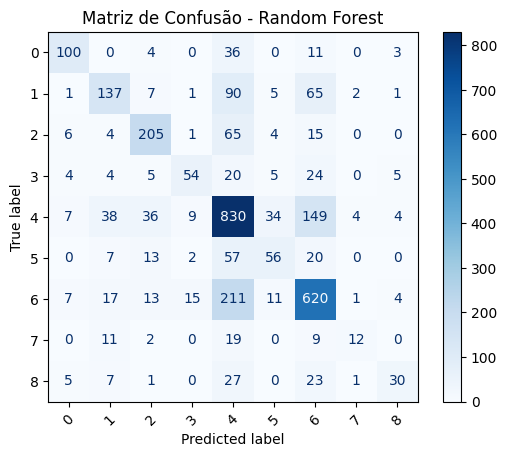

<Figure size 1000x800 with 0 Axes>

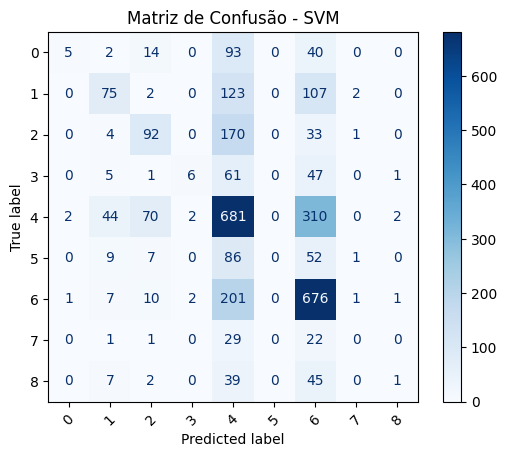

In [35]:
# loop para treinar e avaliar os modelos
for nome, modelo in modelos.items():
    # aplicar padronização se necessário (SVM e RegLog)
    if nome in ['Regressão Logística', 'SVM']:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
        modelos_treinados[nome] = modelo
        X_test_final = X_test_scaled
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        modelos_treinados[nome] = modelo
        X_test_final = X_test

    # métricas
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    resultados.append({
        'Modelo': nome,
        'Acurácia': acc,
        'F1-score (Macro)': f1_macro,
        'F1-score (Weighted)': f1_weighted
    })

    # plotar matriz de confusão
    plot_matriz_confusao(modelo, nome, X_test_final, y_test, labels=classes_unicas)

In [36]:
# exibir ranking final
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='F1-score (Macro)', ascending=False)

,Modelo,Acurácia,F1-score (Macro),F1-score (Weighted)
1,Random Forest,0.639549,0.551892,0.631529
0,Regressão Logística,0.496871,0.263337,0.453271
2,SVM,0.480601,0.221923,0.425957


## 7. Interpretação Final dos Modelos de Classificação

### 🧠 Modelos Avaliados

- **Regressão Logística**
- **Random Forest**
- **SVM (Support Vector Machine)**

---

### 🥇 Desempenho Geral

| Modelo              | Acurácia | F1-score (Macro) | F1-score (Weighted) |
|---------------------|----------|------------------|----------------------|
| **Random Forest**   | 0.6395   | **0.5519**       | **0.6315**           |
| Regressão Logística | 0.4969   | 0.2633           | 0.4533               |
| SVM                 | 0.4806   | 0.2219           | 0.4260               |

- **Random Forest** obteve os melhores resultados em todas as métricas avaliadas.
- **SVM** e **Regressão Logística** apresentaram desempenho significativamente inferior, com baixa capacidade de generalização.

---

### 📉 Acurácia vs. F1-score

- A acurácia, embora razoável para Random Forest, **não é suficiente** como única métrica — devido ao **forte desbalanceamento das classes**.
- O **F1-score macro** evidencia esse desequilíbrio, pois mede o desempenho médio por classe, sem considerar o número de amostras.
  - Exemplo: RegLog tem acurácia de ~50%, mas F1-macro de apenas ~26%.

---

### 📌 Observações Relevantes

#### 1. **Classes Desbalanceadas**
- Algumas classes, como `7`, `9` e `11`, têm **poucas amostras** e não são previstas pelos modelos (F1 ≈ 0).
- As classes `5` e `12`, com **maior volume de dados**, dominam as predições e distorcem as métricas.

#### 2. **Zero Precision/Recall**
- Modelos como SVM e Regressão Logística **não preveem algumas classes em nenhum caso**, levando a avisos de *"zero precision"* do `sklearn`.

#### 3. **Random Forest se destacou**
- Melhor cobertura geral das classes minoritárias.
- Apresentou menos confusão entre rótulos próximos nas matrizes de confusão.

---

### 📉 Matrizes de Confusão

- **Regressão Logística e SVM** têm forte viés para as classes mais comuns, errando consistentemente nas minoritárias.
- **Random Forest** foi o único que distribuiu razoavelmente bem as predições, mesmo para classes menos frequentes.

---

### ✅ Conclusão Final

- **Random Forest é o modelo mais indicado para o problema atual**, mesmo com o desbalanceamento severo.
- Modelos lineares, como Regressão Logística e SVM, **não conseguiram lidar com a distribuição desequilibrada** e a complexidade do problema.
- **Possíveis próximos passos:**
  - Aplicar **estratégias de balanceamento de classes**, como `SMOTE` ou `class_weight`.
  - Testar modelos como **XGBoost** ou **LightGBM** para possível ganho de performance.
  - Analisar o impacto de redução/agrupamento de classes, se aplicável ao negócio.
